In [1]:
import os
import pandas as pd
from tqdm import tqdm
import torch

from sklearn.metrics.pairwise import cosine_similarity
from rdkit.Chem import CanonSmiles, MolFromSmiles, PandasTools, MolToSmiles

from mhfp.encoder import MHFPEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Disable warnings
from rdkit import RDLogger
import warnings

RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")
PandasTools.RenderImagesInAllDataFrames(images=True)
sns.set(style="whitegrid")

# Load model and training data

In [3]:
fingerprint_name = "mhfp6"
model_name = "rf"
model = torch.load(f"../models/{fingerprint_name}_{model_name}.pkl")

In [4]:
training_df = pd.read_csv("../data/splits/mhfp6_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,cmp_id,label
0,106238389,19585817,17313015,85580138,2283851,9308294,114891348,330151044,4622583,32705546,...,21431025,1416250,23808403,43519231,84245819,8268284,92664381,15029722,GJONUWKZTGXFCZ-UHFFFAOYSA-N,fungi
1,3517916,33988699,16482348,70316072,11199736,177666938,7058993,36401732,31460943,13779754,...,7031338,1416250,14468176,41181622,12309677,442438,39402493,119091590,KNKXUUOLURWKKV-UHFFFAOYSA-N,gram-negative


# Load testing data - EU-OS Library

In [5]:
euos_df = pd.DataFrame()

for file in os.listdir("../data/benchmark"):
    if "EOS" not in file:
        continue
    df = pd.read_csv(f"../data/benchmark/{file}")
    df = df[["eos", "activity", "smiles", "inchikey"]]
    df.rename(columns={"activity": file.split(".")[0]}, inplace=True)
    df.set_index("eos", inplace=True)
    if euos_df.empty:
        euos_df = df
    else:
        euos_df = euos_df.join(df, how="outer", lsuffix="{file}_")

In [6]:
cols_to_keep = [i for i in euos_df.columns if "{file}_" not in i]
euos_df = euos_df[cols_to_keep]
euos_df.head(2)

,CandidaAlb_fungi_EOS300076_65,AspFumigatus_fungi_EOS300074_64,CandidaAuris_fungi_EOS300072_63,StaphA_EOS300078_66_GPlus,E_faecalis_EOS300080_67_GPlus,smiles,inchikey
eos,,,,,,,
EOS1,inactive,inactive,inactive,inactive,inactive,COc1ccc(N2C(=O)NC(CC(=O)N3CCC(c4ccccc4)CC3)C2=...,BDSKOWUCRDTSBA-UHFFFAOYSA-N
EOS10,inactive,inactive,inactive,inactive,inactive,CC(C)CC(NC(=O)CCC1NC(=O)N(c2ccccc2)C1=O)c1nnc2...,QMRVFTLYUYCNQY-UHFFFAOYSA-N


In [7]:
# Adding in latest results
gram_negative_actives = """EOS2202
EOS24472
EOS100321
EOS100573
EOS100586
EOS100698
EOS100925
EOS100994
EOS101209
EOS101641
EOS101978
EOS102146
EOS102156
EOS102273"""
gram_negative_actives = gram_negative_actives.split("\n")

In [8]:
euos_df["gram_negative"] = euos_df.index.isin(gram_negative_actives)
euos_df["gram_negative"] = euos_df["gram_negative"].apply(
    lambda x: "active" if x else "inactive"
)

### Cleaning the EU-OS data for better analysis

In [9]:
euos_df.rename(
    columns={
        "CandidaAlb_fungi_EOS300076_65": "Fungi_candida",
        "AspFumigatus_fungi_EOS300074_64": "Fungi_aspergillus",
        "CandidaAuris_fungi_EOS300072_63": "Fungi_candida_auris",
        "StaphA_EOS300078_66_GPlus": "Gram_positive_staph",
        "E_faecalis_EOS300080_67_GPlus": "Gram_positive_enterococcus",
    },
    inplace=True,
)

In [10]:
final_class = []

for fungi_1, fungi_2, fungi_2, gp1, gp2, gn in tqdm(
    euos_df[
        [
            "Fungi_candida",
            "Fungi_aspergillus",
            "Fungi_candida_auris",
            "Gram_positive_staph",
            "Gram_positive_enterococcus",
            "gram_negative",
        ]
    ].values
):
    if "active" in [fungi_1, fungi_2, fungi_2]:
        fungi = True
    elif "inactive" in [fungi_1, fungi_2, fungi_2]:
        fungi = False

    if "active" in [gp1, gp2]:
        gp = True
    elif "inactive" in [gp1, gp2]:
        gp = False

    if "active" in [gn]:
        gn = True
    elif "inactive" in [gn]:
        gn = False

    if fungi and gp and gn:
        final_class.append("fungi, gram-positive, gram-negative")
    elif fungi and gp:
        final_class.append("fungi, gram-positive")
    elif fungi and gn:
        final_class.append("fungi, gram-negative")
    elif gp and gn:
        final_class.append("gram-positive, gram-negative")
    elif fungi:
        final_class.append("fungi")
    elif gp:
        final_class.append("gram-positive")
    elif gn:
        final_class.append("gram-negative")
    else:
        final_class.append("unknown")

euos_df["final_class"] = final_class

100%|██████████| 101024/101024 [00:00<00:00, 1374103.31it/s]


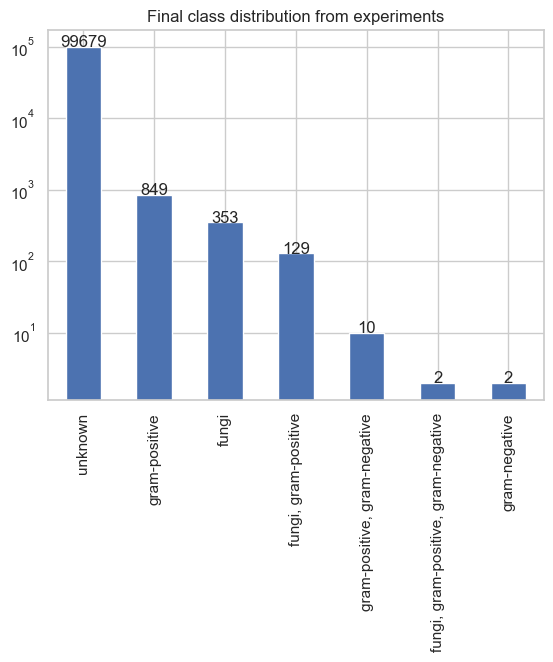

In [11]:
euos_df["final_class"].value_counts().plot(kind="bar")
plt.title("Final class distribution from experiments")
plt.yscale("log")

# display counts on top of bars
for i in range(len(euos_df["final_class"].value_counts())):
    plt.text(
        i,
        euos_df["final_class"].value_counts().values[i],
        euos_df["final_class"].value_counts().values[i],
        ha="center",
    )

plt.show()

# Generate fingerprints

In [12]:
mhfp_encoder = MHFPEncoder(n_permutations=2048, seed=42)  # MHFP6 fingerprint

In [13]:
mhfp6_fingerprints = []

for smiles in tqdm(euos_df["smiles"].values):
    # Generate the mol object
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        mhfp6_fingerprints.append(None)
        continue

    mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))

euos_df[fingerprint_name] = mhfp6_fingerprints

100%|██████████| 101024/101024 [13:54<00:00, 121.09it/s]


# Performing predictions

In [14]:
predictions = model.predict(euos_df[fingerprint_name].tolist())
prediction_proba = model.predict_proba(euos_df[fingerprint_name].tolist())
label_classes = model.classes_.tolist()

In [15]:
euos_df["prediction"] = predictions

In [16]:
probs = []

for idx, probability in enumerate(prediction_proba):
    predicted_class = predictions[idx]
    probs.append(probability[label_classes.index(predicted_class)])

euos_df["probability"] = probs

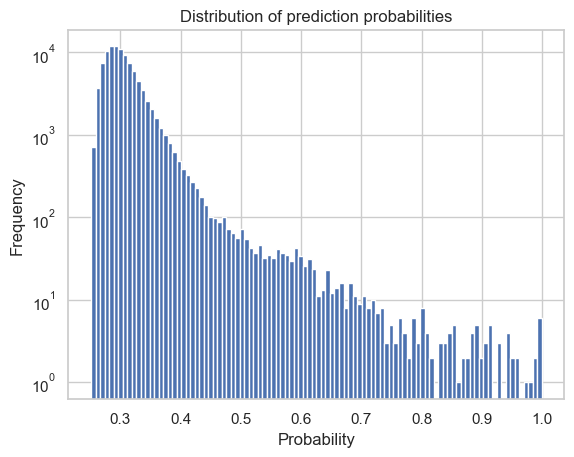

In [17]:
sns.set(style="whitegrid")
euos_df["probability"].plot(kind="hist", bins=100)
plt.yscale("log")
plt.xlabel("Probability")
plt.title("Distribution of prediction probabilities")
plt.show()

# Looking at similarity with training dataset

In [18]:
training_cmpds = []

for row in tqdm(training_df.values):
    cmpd_fingerprint = row[:-2]
    training_cmpds.append(cmpd_fingerprint)

100%|██████████| 59361/59361 [00:00<00:00, 3369942.34it/s]


In [19]:
len(training_cmpds), len(mhfp6_fingerprints)

(59361, 101024)

In [20]:
cosine_df = cosine_similarity(mhfp6_fingerprints, training_cmpds)

In [21]:
max_similarity_scores = []

for sim_row in tqdm(cosine_df):
    max_similarity_scores.append(max(sim_row))

100%|██████████| 101024/101024 [09:31<00:00, 176.68it/s]


In [22]:
euos_df["training_set_similarity"] = max_similarity_scores

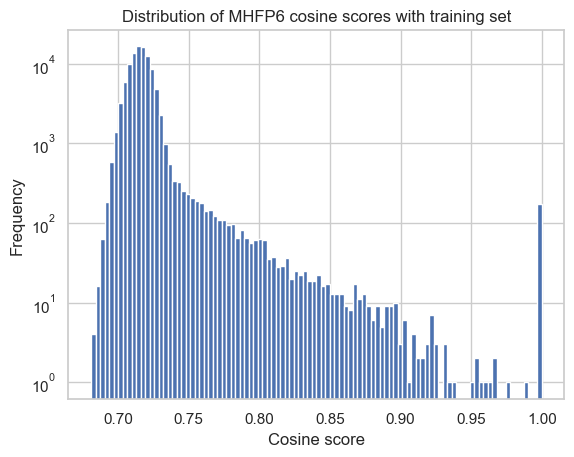

In [23]:
# Distribution of similarity scores with training set
euos_df["training_set_similarity"].plot(kind="hist", bins=100)
plt.yscale("log")
plt.xlabel("Cosine score")
plt.title("Distribution of MHFP6 cosine scores with training set")
plt.show()

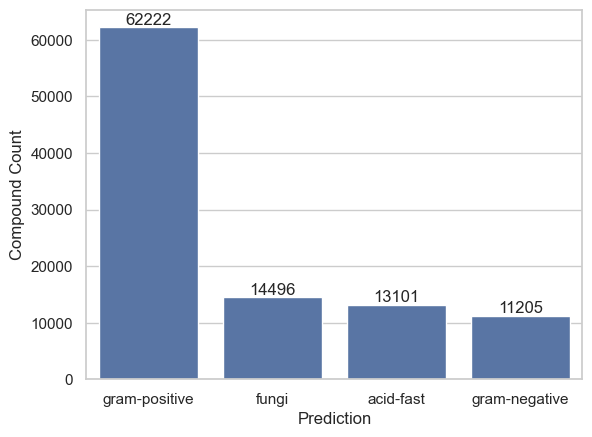

In [24]:
pred_count = euos_df["prediction"].value_counts()
sns.barplot(
    x=pred_count.index,
    y=pred_count.values,
    order=pred_count.index,
)
plt.xlabel("Prediction")
plt.ylabel("Compound Count")
# show counts on the bars
for idx, count in enumerate(pred_count.values):
    plt.text(idx, count, count, ha="center", va="bottom")
plt.show()

# Saving the predictions

In [25]:
euos_df_subset = euos_df[
    [
        "smiles",
        "inchikey",
        "final_class",
        "prediction",
        "probability",
        "training_set_similarity",
    ]
]

In [26]:
os.makedirs("../data/predictions", exist_ok=True)
euos_df_subset.to_csv("../data/predictions/euos_predictions.csv")